# Analysis of Critical Aggregation Concentration of Kinase Inhibitors by DLS

### Set 1 Ligands 
- Axitinib (Rows A and B)
- Erlotinib (Rows C and D)
- Gefitinib (Rows E and F)
- Imatinib (Rows G and H)


### Titration 
- 24 point, linear titration
- titration range 1 uM - 80 uM (A1 highest conc, A24 lowest conc)

In [1]:
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams.update({'font.size': 14})

In [17]:
def extract_normalized_intensity(DLS_data, well_dictionary, ligand = "bosutinib", number_of_sections = 2 , number_of_wells_in_each_section = 12):
    """
    For specified ligand, returns a numpy array of normalized intensity values 
    where replicates are concatanated after each other.
    """
    ALPHABET = string.ascii_uppercase

    # construct a dictionary that keeps well labels for each replicate keeping experimental order
    
    section_well_labels = {}

    for i in range(number_of_sections):

        well_interval = ligands[ligand][i]
        print(well_interval)
        first_well, last_well = well_interval.split("-")
        #print(first_well, last_well)

        # determine if well series in each section was positioned horizontally or vertically
        if first_well[0:1] == last_well[0:1]:
            print("Section {} is placed horizontally".format(i+1))
            row_name = first_well[0:1]

            well_name_list = []
            for j in range(number_of_wells_in_each_section):
                well_label = row_name + str(j+1)
                well_name_list.append(well_label)
            #print(well_name_list)
            section_well_labels["sec{}".format(i+1)] = well_name_list
            #print('section_well_labels', section_well_labels)

        else:
            #print("Section {} is placed vertically".format(i+1))
            column_name = first_well[1:]

            well_name_list = []
            for j in range(number_of_wells_in_each_section):
                well_label = ALPHABET[j] + column_name
                well_name_list.append(well_label)
            #print(well_name_list)
            section_well_labels["sec{}".format(i+1)] = well_name_list
            
    # Concatanate well labels of all sections to achieve full well name list
    
    full_well_name_list = [] # Concatanate well labels of all sections to achieve full well name list
    
    for i in range(number_of_sections):
        well_name_list = section_well_labels["sec{}".format(i+1)]
        full_well_name_list = full_well_name_list + well_name_list
        
    print("full_well_name_list:\n", full_well_name_list )
    
    
    # Create numpy array for normalized intensity data 
    
    norm_int_array = np.zeros([number_of_sections*number_of_wells_in_each_section])

    for j, well_name in enumerate(full_well_name_list):
            norm_int = DLS_data.loc[DLS_data["Well"] == well_name]["Normalized Intensity (Cnt/s)"].values[0]
            #print(well_name, norm_int)
            
            # If normalized intensity not calculated, record it as np.NaN
            if norm_int == "--":
                norm_int = np.NaN
            norm_int_array[j] = norm_int
            
    return(norm_int_array)

def create_critical_aggrecation_concentration_plot(concentrations, normalized_intensity_values_1, normalized_intensity_values_2, normalized_intensity_values_3, ligand_name):
    figure = plt.figure()
    with sns.color_palette("colorblind"):
        plt.plot(concentrations, normalized_intensity_values_1, "o", label='Replicate 1', markersize=4, alpha=0.6)
        plt.plot(concentrations, normalized_intensity_values_2, "o", label='Replicate 2', markersize=4, alpha=0.6)
        plt.plot(concentrations, normalized_intensity_values_3, "o", label='Replicate 3', markersize=4, alpha=0.6)
        plt.hlines(0.1e+7, 0, 80, linestyles='dashed', label='DMSO', lw=1)
#         plt.fill_between(x, 1e8, y2=0, color='0.75', alpha=0.4)
        plt.legend(loc='upper left', prop={'size': 11})
        plt.xlabel("Concentration ($\mu$M)", size=15)
        plt.ylabel("Average normalized intensity (Cnt/s)", size=12)
        plt.ylim(0, 1e+8)
        plt.title(ligand_name, size=18)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.show()
    return(figure)

In [3]:
# List well boundaries of titration replicates as dictionary values, 
# in the direction of increasing ligand concentration
#Ponatinib5 is in a different file

ligands = {"Axitinib Free Base":["A1-A12","B1-B12"], 
           "Erlotinib": ["C1-C12","D1-D12"], 
           "Gefitinib Free Base": ["E1-E12", "F1-F12"],
           "Imatinib Methanesulfonate Salt": ["G1-G12", "H1-H12"]}

ligands.keys()

dict_keys(['Axitinib Free Base', 'Erlotinib', 'Gefitinib Free Base', 'Imatinib Methanesulfonate Salt'])

In [4]:
# Titration of Ligand Concentrations
conc_array = np.array([80.0,76.5652173913,73.1304347826,69.6956521739,66.2608695652,62.8260869565,59.3913043478,55.9565217391,52.5217391304,49.0869565217,45.652173913,42.2173913043,38.7826086957,35.347826087,31.9130434783,28.4782608696,25.0434782609,21.6086956522,18.1739130435,14.7391304348,11.3043478261,7.86956521739,4.4347826087,1.0], np.float64)
conc_array

array([ 80.        ,  76.56521739,  73.13043478,  69.69565217,
        66.26086957,  62.82608696,  59.39130435,  55.95652174,
        52.52173913,  49.08695652,  45.65217391,  42.2173913 ,
        38.7826087 ,  35.34782609,  31.91304348,  28.47826087,
        25.04347826,  21.60869565,  18.17391304,  14.73913043,
        11.30434783,   7.86956522,   4.43478261,   1.        ])

## 1. Analysis of Read 1 (5 s acquisition, 5 acquisitions)

In [5]:
# Extract Normalized Intensity Array from DLS file for file 1
data_file_1 = "kinase_inh_DLS_new_set_1_time_0_5sacq_20181010.csv"
df_read1 = pd.read_csv(data_file_1)
df_read1.head()

,Item,Time (s),Image,Intensity (Cnt/s),DLS Temp (C),Radius (nm),Amplitude,%PD,Mw-R (kDa),Baseline,...,Number Acqs,Number Unmarked Acqs,Number Marked Acqs,Acq Time (s),Solvent,Rfr Idx @ 589nm & 20C,Viscosity (cP),Temp Model,Time Stamp,Laser Power (%)
0,A1,7500.0,View,1708938,25.0,216.4,0.125,0.0,980112.4,1.047,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,13:23:48,10.0
1,A2,7500.0,View,1023857,25.0,296.5,0.245,0.0,2047715.4,0.972,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,13:24:27,10.0
2,A3,7600.0,View,733778,25.0,73.3,0.085,Multimodal,77783.3,1.000,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,13:25:05,10.0
3,A4,7600.0,View,386832,25.0,59.1,0.057,Multimodal,46956.2,1.004,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,13:25:44,10.0
4,A5,7700.0,View,1031231,25.0,216.5,0.202,0.0,980995.8,1.010,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,13:26:23,10.0


In [6]:
# Extract Normalized Intensity Array from DLS file for file 2
data_file_2 = "kinase_inh_DLS_new_set_1_plate_2_time_0_5sacq_20181015.csv"
df_read2 = pd.read_csv(data_file_2)
df_read2.head()

,Item,Time (s),Image,Intensity (Cnt/s),DLS Temp (C),Radius (nm),Amplitude,%PD,Mw-R (kDa),Baseline,...,Number Acqs,Number Unmarked Acqs,Number Marked Acqs,Acq Time (s),Solvent,Rfr Idx @ 589nm & 20C,Viscosity (cP),Temp Model,Time Stamp,Laser Power (%)
0,A1,0.0,View,234073,25.1,268.3,0.235,Multimodal,1621207.1,1.381,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,11:13:48,10.0
1,A2,48.0,View,446804,25.1,100.8,0.083,Multimodal,163921.1,1.021,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,11:14:36,10.0
2,A3,87.0,View,200425,25.0,83.8,0.128,Multimodal,106462.6,1.060,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,11:15:15,10.0
3,A4,130.0,View,201064,25.0,92.5,0.099,Multimodal,134113.9,1.063,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,11:15:53,10.0
4,A5,160.0,View,425076,25.0,196.4,0.143,Multimodal,780794.7,1.037,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,11:16:32,10.0


In [7]:
# Extract Normalized Intensity Array from DLS file for file 3
data_file_3 = "kinase_inh_DLS_new_set_1_plate_3_time_0_5sacq_20181018.csv"
df_read3 = pd.read_csv(data_file_3)
df_read3.head()

,Item,Time (s),Image,Intensity (Cnt/s),DLS Temp (C),Radius (nm),Amplitude,%PD,Mw-R (kDa),Baseline,...,Number Acqs,Number Unmarked Acqs,Number Marked Acqs,Acq Time (s),Solvent,Rfr Idx @ 589nm & 20C,Viscosity (cP),Temp Model,Time Stamp,Laser Power (%)
0,A1,0.0,View,351120,25.1,187.1,0.169,Multimodal,697550.4,1.093,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,11:09:53,10.0
1,A2,38.0,View,411676,25.1,348.6,0.162,Multimodal,2990407.7,1.194,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,11:10:31,10.0
2,A3,76.0,View,209308,25.1,74.6,0.065,Multimodal,81172.3,1.008,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,11:11:09,10.0
3,A4,110.0,View,431623,25.0,105.3,0.064,Multimodal,181538.2,1.034,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,11:11:47,10.0
4,A5,150.0,View,366167,25.0,89.6,0.111,Multimodal,124666.3,1.060,...,5,5,0,5.0,Water,1.333,0.89,Aqueous,11:12:25,10.0


In [8]:
df_read1.columns

Index(['Item', 'Time (s)', 'Image', 'Intensity (Cnt/s)', 'DLS Temp (C)',
       'Radius (nm)', 'Amplitude', '%PD', 'Mw-R (kDa)', 'Baseline', 'SOS',
       'Measurement ID', 'Well', 'Normalized Intensity (Cnt/s)', 'Number Acqs',
       'Number Unmarked Acqs', 'Number Marked Acqs', 'Acq Time (s)', 'Solvent',
       'Rfr Idx @ 589nm & 20C', 'Viscosity (cP)', 'Temp Model', 'Time Stamp',
       'Laser Power (%)'],
      dtype='object')

In [9]:
df_read2.columns

Index(['Item', 'Time (s)', 'Image', 'Intensity (Cnt/s)', 'DLS Temp (C)',
       'Radius (nm)', 'Amplitude', '%PD', 'Mw-R (kDa)', 'Baseline', 'SOS',
       'Measurement ID', 'Well', 'Normalized Intensity (Cnt/s)', 'Number Acqs',
       'Number Unmarked Acqs', 'Number Marked Acqs', 'Acq Time (s)', 'Solvent',
       'Rfr Idx @ 589nm & 20C', 'Viscosity (cP)', 'Temp Model', 'Time Stamp',
       'Laser Power (%)'],
      dtype='object')

In [10]:
df_read3.columns

Index(['Item', 'Time (s)', 'Image', 'Intensity (Cnt/s)', 'DLS Temp (C)',
       'Radius (nm)', 'Amplitude', '%PD', 'Mw-R (kDa)', 'Baseline', 'SOS',
       'Measurement ID', 'Well', 'Normalized Intensity (Cnt/s)', 'Number Acqs',
       'Number Unmarked Acqs', 'Number Marked Acqs', 'Acq Time (s)', 'Solvent',
       'Rfr Idx @ 589nm & 20C', 'Viscosity (cP)', 'Temp Model', 'Time Stamp',
       'Laser Power (%)'],
      dtype='object')

In [11]:
df_read1_summary = df_read1.loc[:, ("Well",'Normalized Intensity (Cnt/s)', 'Acq Time (s)', 'Number Acqs', 'Number Marked Acqs', 'Laser Power (%)') ]
df_read1_summary.head()

,Well,Normalized Intensity (Cnt/s),Acq Time (s),Number Acqs,Number Marked Acqs,Laser Power (%)
0,A1,17089377,5.0,5,0,10.0
1,A2,10238569,5.0,5,0,10.0
2,A3,7337777,5.0,5,0,10.0
3,A4,3868316,5.0,5,0,10.0
4,A5,10312311,5.0,5,0,10.0


In [12]:
df_read2_summary = df_read2.loc[:, ("Well",'Normalized Intensity (Cnt/s)', 'Acq Time (s)', 'Number Acqs', 'Number Marked Acqs', 'Laser Power (%)') ]
df_read2_summary.head()

,Well,Normalized Intensity (Cnt/s),Acq Time (s),Number Acqs,Number Marked Acqs,Laser Power (%)
0,A1,2340727,5.0,5,0,10.0
1,A2,4468036,5.0,5,0,10.0
2,A3,2004253,5.0,5,0,10.0
3,A4,2010640,5.0,5,0,10.0
4,A5,4250764,5.0,5,0,10.0


In [13]:
df_read3_summary = df_read3.loc[:, ("Well",'Normalized Intensity (Cnt/s)', 'Acq Time (s)', 'Number Acqs', 'Number Marked Acqs', 'Laser Power (%)') ]
df_read3_summary.head()

,Well,Normalized Intensity (Cnt/s),Acq Time (s),Number Acqs,Number Marked Acqs,Laser Power (%)
0,A1,3511202,5.0,5,0,10.0
1,A2,4116756,5.0,5,0,10.0
2,A3,2093076,5.0,5,0,10.0
3,A4,4316226,5.0,5,0,10.0
4,A5,3661669,5.0,5,0,10.0


A1-A12
Section 1 is placed horizontally
B1-B12
Section 2 is placed horizontally
full_well_name_list:
 ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12']
Normalized Intensity (Cnt/s)
 [ 17089377.  10238569.   7337777.   3868316.  10312311.  15328325.
   3589677.   4941468.   4201012.   2971482.   4071118.   3151853.
   2853202.   1205392.    989817.   1195750.   1135763.   3213436.
    924531.   1354608.   3123740.    718536.    611195.   1146147.]
A1-A12
Section 1 is placed horizontally
B1-B12
Section 2 is placed horizontally
full_well_name_list:
 ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12']
Normalized Intensity (Cnt/s)
 [  2.34072700e+06   4.46803600e+06   2.00425300e+06   2.01064000e+06
   4.25076400e+06   2.81780500e+06   7.26484300e+06   1.22584703e+08
   4.71683420e+07   6.65977

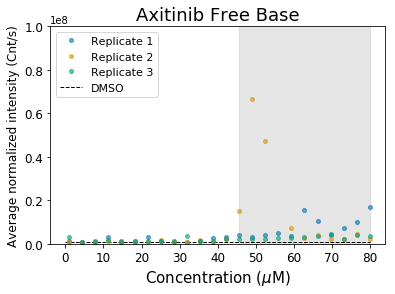

In [16]:
pdf = PdfPages("20181105_kinase_inh_axi_10^8_comparison_manual_settings_CAC.pdf")

norm_int_array_1 = extract_normalized_intensity(DLS_data = df_read1, well_dictionary = ligands, ligand = "Axitinib Free Base" )
print("Normalized Intensity (Cnt/s)\n", norm_int_array_1)
norm_int_array_2 = extract_normalized_intensity(DLS_data = df_read2, well_dictionary = ligands, ligand = "Axitinib Free Base" )
print("Normalized Intensity (Cnt/s)\n", norm_int_array_2)
norm_int_array_3 = extract_normalized_intensity(DLS_data = df_read3, well_dictionary = ligands, ligand = "Axitinib Free Base" )
print("Normalized Intensity (Cnt/s)\n", norm_int_array_3)

plot = create_critical_aggrecation_concentration_plot(concentrations = conc_array, normalized_intensity_values_1 = norm_int_array_1, normalized_intensity_values_2 = norm_int_array_2, normalized_intensity_values_3 = norm_int_array_3, x = [45.7, 80], ligand_name = "Axitinib Free Base")
plt.show(plot)

pdf.savefig(plot)
    
pdf.close()

E1-E12
Section 1 is placed horizontally
F1-F12
Section 2 is placed horizontally
full_well_name_list:
 ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12']
Normalized Intensity (Cnt/s)
 [  953447.   833360.   927216.   970608.   705216.   970426.   833469.
  1122892.   931951.  1530086.   611286.   693314.   511396.  2873060.
   828117.   983178.   861343.   931460.   895980.   532336.  1482411.
   862775.   473124.   590156.]
E1-E12
Section 1 is placed horizontally
F1-F12
Section 2 is placed horizontally
full_well_name_list:
 ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12']
Normalized Intensity (Cnt/s)
 [  867236.   748284.  3617839.  1011639.  1263956.   775988.   581756.
   878159.   887786.   743070.  1899675.  3359361.   521378.   702276.
   720784.   537161.   656186.   777216.   5912

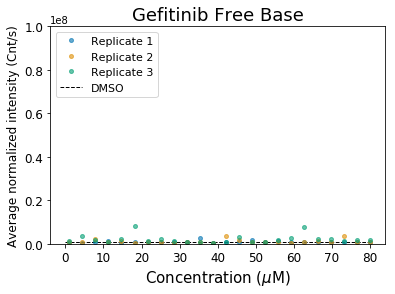

In [18]:
pdf = PdfPages("20181105_kinase_inh_gef_10^8_comparison_manual_settings_CAC.pdf")

norm_int_array_1 = extract_normalized_intensity(DLS_data = df_read1, well_dictionary = ligands, ligand = "Gefitinib Free Base" )
print("Normalized Intensity (Cnt/s)\n", norm_int_array_1)
norm_int_array_2 = extract_normalized_intensity(DLS_data = df_read2, well_dictionary = ligands, ligand = "Gefitinib Free Base" )
print("Normalized Intensity (Cnt/s)\n", norm_int_array_2)
norm_int_array_3 = extract_normalized_intensity(DLS_data = df_read3, well_dictionary = ligands, ligand = "Gefitinib Free Base" )
print("Normalized Intensity (Cnt/s)\n", norm_int_array_3)

plot = create_critical_aggrecation_concentration_plot(concentrations = conc_array, normalized_intensity_values_1 = norm_int_array_1, normalized_intensity_values_2 = norm_int_array_2, normalized_intensity_values_3 = norm_int_array_3, ligand_name = "Gefitinib Free Base")
plt.show(plot)

pdf.savefig(plot)
    
pdf.close()

G1-G12
Section 1 is placed horizontally
H1-H12
Section 2 is placed horizontally
full_well_name_list:
 ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12']
Normalized Intensity (Cnt/s)
 [  697799.   564710.   695881.   714520.  1131330.   696205.   817726.
  1920152.   890777.   821687.   884512.   548975.   585806.   848541.
   835448.   619335.   440382.   558926.   605881.   588164.   852623.
   432283.   567532.  6909000.]
G1-G12
Section 1 is placed horizontally
H1-H12
Section 2 is placed horizontally
full_well_name_list:
 ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12']
Normalized Intensity (Cnt/s)
 [  501380.   501922.   621142.   745929.   694709.   714339.   664658.
  1590526.   682215.   688719.  1362167.  1248320.   922267.   519510.
   491014.   433741.   599730.   582419.  10602

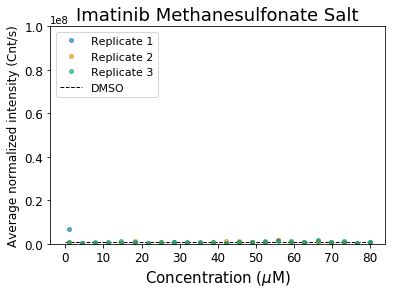

In [19]:
pdf = PdfPages("20181105_kinase_inh_ima_10^8_comparison_manual_settings_CAC.pdf")

norm_int_array_1 = extract_normalized_intensity(DLS_data = df_read1, well_dictionary = ligands, ligand = "Imatinib Methanesulfonate Salt")
print("Normalized Intensity (Cnt/s)\n", norm_int_array_1)
norm_int_array_2 = extract_normalized_intensity(DLS_data = df_read2, well_dictionary = ligands, ligand = "Imatinib Methanesulfonate Salt")
print("Normalized Intensity (Cnt/s)\n", norm_int_array_2)
norm_int_array_3 = extract_normalized_intensity(DLS_data = df_read3, well_dictionary = ligands, ligand = "Imatinib Methanesulfonate Salt")
print("Normalized Intensity (Cnt/s)\n", norm_int_array_3)

plot = create_critical_aggrecation_concentration_plot(concentrations = conc_array, normalized_intensity_values_1 = norm_int_array_1, normalized_intensity_values_2 = norm_int_array_2, normalized_intensity_values_3 = norm_int_array_3, ligand_name = "Imatinib Methanesulfonate Salt")
plt.show(plot)

pdf.savefig(plot)
    
pdf.close()
                                                

In [ ]:
# # Save plots in a pdf
# pdf = PdfPages("20181024_kinase_inh_axi_gef_ima_10^8_comparison_manual_settings_CAC.pdf")

# for lig in ligands.keys():
#     if lig != "Erlotinib":
#         norm_int_array_1 = extract_normalized_intensity(DLS_data = df_read1, well_dictionary = ligands, ligand = lig )
#         norm_int_array_2 = extract_normalized_intensity(DLS_data = df_read2, well_dictionary = ligands, ligand = lig )
#         norm_int_array_3 = extract_normalized_intensity(DLS_data = df_read3, well_dictionary = ligands, ligand = lig )

#         plot = create_critical_aggrecation_concentration_plot(concentrations = conc_array, normalized_intensity_values_1 = norm_int_array_1, normalized_intensity_values_2 = norm_int_array_2, normalized_intensity_values_3 = norm_int_array_3, ligand_name = lig)
#         pdf.savefig(plot)
    
# pdf.close()

### Attempt to create a tidy PDF for comparison

In [ ]:
def create_CAC_grid_plot(concentrations, normalized_intensity_values, ligand_name, grid_x, grid_y):
    figure = plt.figure(figsize=(8.27, 11.69), dpi=100)
    plt.subplot2grid(grid_size, (grid_x, grid_y))
    plt.plot(concentrations, normalized_intensity_values, "o", alpha = 0.5)
    plt.xlabel("Concentration (uM)")
    plt.ylabel("Average normalized intensity (Cnt/s)")
    plt.ylim(0, 1e+8)
    plt.title(ligand_name)
    #plt.show()
    return(figure)